## Capstone Project: Toxic Comment Classification

---

This project is about online comments classification, which is based on a public Kaggle competition
Toxic Comment Classification Challenge. For more detailed discussion, please check the capstone report.

---
### Dataset

The dataset contains about 160k human labeled comments from Wikipedia Talk pages. The labeled annotations are obtained by asking 5000 crowd-workers to rate Wikipedia comments according to their toxicity. The paper "Ex Machina: Personal Attacks Seen at Scale" describes in details the approach to generating a corpus of discussion comments from English
Wikipedia. The dataset can be downloaded from here:

* Toxic Comment Dataset
  https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

### Outline

The notebook is divided into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Data
* [Step 1](#step1): Data Exploration and Exploratory Visualization
* [Step 2](#step2): Prepare the Data
* [Step 3](#step3): Logistic Regression model (Benchmark)
* [Step 4](#step4): Convolutional Neural Network (CNN) model
* [Step 5](#step5): Recurrent Neural Network (RNN) model
* [Step 6](#step6): Transfer Learning (GloVe) model


---
<a id='step0'></a>
## Step 0: Import Data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import string
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

#settings
color = sns.color_palette()
sns.set_style("whitegrid")
stopwords_eng = set(stopwords.words("english"))

Using TensorFlow backend.


In [2]:
# load text data
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')
submission = pd.read_csv('sample_submission.csv')
print('Trainning set contains {} records and testing set contains {} records.'.format(len(train),len(test)))

Trainning set contains 159571 records and testing set contains 153164 records.


---
<a id='step1'></a>
## Step 1: Data Exploration and Exploratory Visualization

### Inspect Dataset

In [32]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
# class imbalance
labels = train.iloc[:,2:8]
row_sum = labels.sum(axis = 1)
# mark comments without any labels as "clean"
train['clean'] = (row_sum == 0)
print('Total comments is {}.'.format(len(train)))
print('The clean comments is {}, which is {} of total comments.'.format(train['clean'].sum(),train['clean'].sum()/len(train)))

Total comments is 159571.
The clean comments is 143346, which is 0.8983211235124177 of total comments.


### Missing Values

In [34]:
# check for missing values in the trainning set
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
missing_train, missing_test

(id               0
 comment_text     0
 toxic            0
 severe_toxic     0
 obscene          0
 threat           0
 insult           0
 identity_hate    0
 clean            0
 dtype: int64, id              0
 comment_text    0
 dtype: int64)

### Example Comments

In [35]:
all_types = ['clean', 'toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in all_types:
    record_number = random.randint(1, train[t].sum())
    print('The {}th record of "{}" comments is:'.format(record_number,t))
    print(train[train[t] == 1].iloc[record_number,1])
    print('')
    

The 47540th record of "clean" comments is:
You're only talking about Massachusetts? Better say so.

The 10198th record of "toxic" comments is:
Wikibofh fuck u u fuckin suck argument is fine u nerd now unblock me

((unblock cause i said so look up))

The 849th record of "severe_toxic" comments is:
you're a cunt
go die in a fire kthx <3

The 7921th record of "obscene" comments is:
I struggle to understand why you give a damn so much. Go put that anger towards something else. The few black, hell minority contestants on survivor hardly ever get recognition. Go suck a penis or something.

The 345th record of "threat" comments is:
Kill Feldspar 

Feldspar is a blathering idiot that should be publicly executed for his attempted use of force in place of honest debate to reconcile differences in opinion. Forever small minded psuedointellectuals such as he hide behind anti violence laws and become masters at manipulation, abuse of rules, and all manner of passive aggressive means to force others

### Distribution of Subtypes

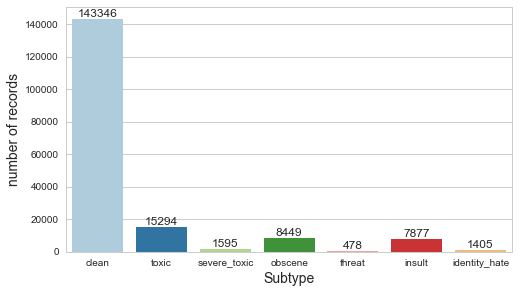

In [4]:
# plot different types of labels
column_sum = pd.Series(labels.sum(axis = 0))
clean = pd.Series(train['clean'].sum(), index = ['clean'])
# add clean document amount as a new type
column_sum = pd.concat([clean, column_sum])

# barplot for different labels
plt.figure(figsize=(8,4.5))
ax = sns.barplot(column_sum.index, column_sum.values, palette = "Paired")
plt.xlabel('Subtype', fontsize = 14)
plt.ylabel('number of records', fontsize = 14)

# add the text labels
for rect, label in zip(ax.patches, column_sum.values):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')

# save the figure as .eps file
fig_subtype = ax.get_figure()
fig_subtype.savefig('figure/subtype.eps')
plt.show()

### Multi-tagging

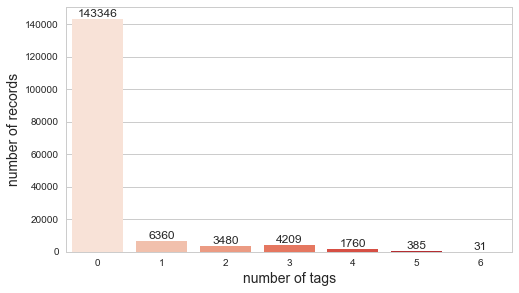

In [5]:
multi_tags = [ sum(row_sum == i) for i in range(7)]
multi_tags = pd.Series(multi_tags, index = [0,1,2,3,4,5,6])
plt.figure()
color_reds = sns.color_palette("Reds", n_colors=7, desat=1)

# barplot for different labels
plt.figure(figsize=(8,4.5))
ax_1 = sns.barplot(multi_tags.index, multi_tags.values, palette = color_reds)
plt.xlabel('number of tags', fontsize = 14)
plt.ylabel('number of records', fontsize = 14)

# add the text labels
for rect, label in zip(ax_1.patches, multi_tags.values):
        ax_1.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,ha = 'center', va='bottom')
        
# save the figure as .eps file
fig_multi_tags = ax_1.get_figure()
fig_multi_tags.savefig('figure/multi_tags.eps')
plt.show()

### Crosstab

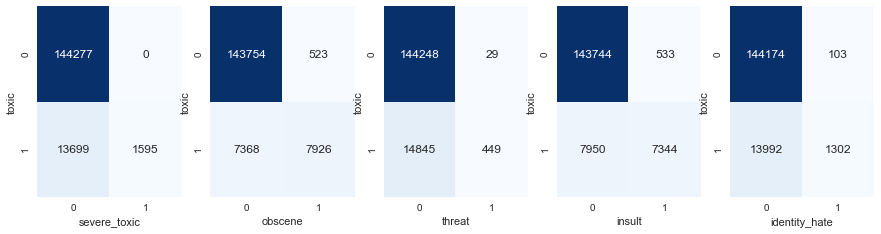

In [8]:
# crosstab
subtypes = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
i = 1
plt.figure(figsize = (15,3.5))
for subtype in subtypes:
    plt.subplot(1,5,i)
    cross = sns.heatmap(pd.crosstab(train['toxic'],train[subtype]),annot = True,
                        fmt = '', cbar = False, cmap = "Blues")
    i += 1
plt.show()  

# save the figure
fig_cross = cross.get_figure()
fig_cross.savefig('figure/crosstab.eps')

### Comments Length Distribution

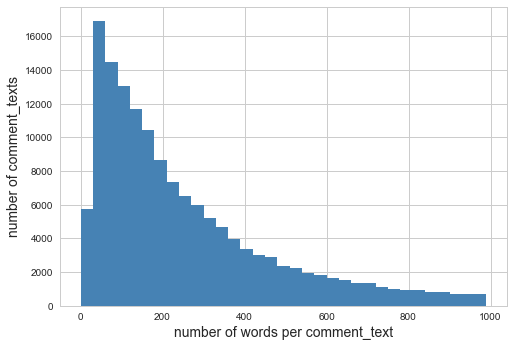

In [9]:
# calculate the number of words per comment
n_words = [len(comment) for comment in train.comment_text]

# histogram plot of the number of words each comment contains
fig_n_words = plt.figure()
plt.hist(n_words,bins = np.arange(0,1000,30), color='steelblue')
plt.xlabel('number of words per comment_text',fontsize=14)
plt.ylabel('number of comment_texts',fontsize=14)
plt.show()

# save the figure
fig_n_words.savefig('figure/n_words.eps')

In [189]:
n_words = pd.Series(n_words)
n_words.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
dtype: float64

### Wordclouds Plot

In [39]:
# frequent words 
def wordcloud_generator(subtype, background, mask_file):
    subset = train[train[subtype] == True]
    subset_text = subset.comment_text.values
    # import mask file
    mask = np.array(Image.open(mask_file))
    mask = mask[:, :, 1]
    # create a wordcloud for the text 
    wordcloud = WordCloud(background_color = background, mask = mask, stopwords = stopwords_eng)
    wordcloud.generate(" ".join(subset_text))    
    return wordcloud

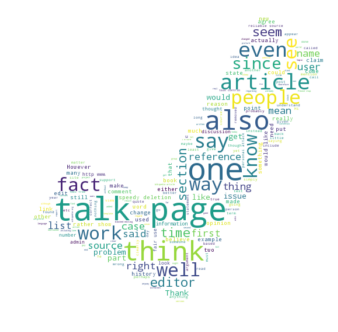

In [40]:
# wordcloud plot for clean comments
wordcloud_clean = wordcloud_generator('clean','white','image/mask_clean.jpg')
wordcloud_clean_plot = plt.imshow(wordcloud_clean.recolor(colormap = 'viridis', random_state = 29), interpolation = 'bilinear')
plt.axis("off")
plt.show()

#save the figure
fig_wordcloud_clean = wordcloud_clean_plot.get_figure()
fig_wordcloud_clean.savefig('figure/wordcloud_clean.eps')

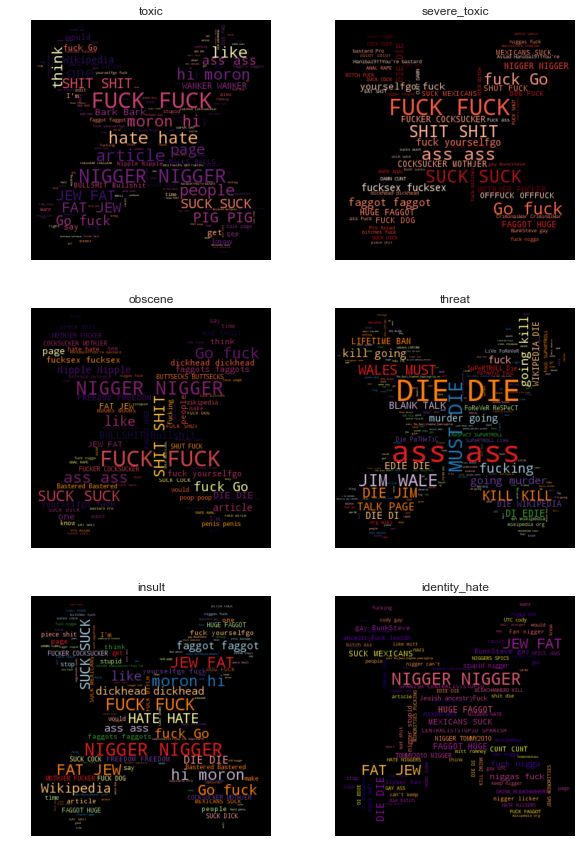

In [41]:
# wordcloud plot for subtypes of toxic comments
toxic_types = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
colormaps = ['magma', 'Reds', 'inferno', 'Paired_r', 'Paired_r', 'plasma']

plt.subplots(3,2, figsize=(10,15))
i = 1
for toxic_type, colormap in zip(toxic_types, colormaps):
    plt.subplot(3,2,i)
    wordcloud_toxic = wordcloud_generator(toxic_type,'black','image/mask_toxic.jpg')
    wordcloud_toxic_plot = plt.imshow(wordcloud_toxic.recolor(colormap = colormap, random_state = 29), interpolation = 'bilinear')
    plt.axis("off")
    plt.gca().set_title(toxic_type)
    i += 1
plt.show()

# save the figure
fig_wordcloud_toxic = wordcloud_toxic_plot.get_figure()
fig_wordcloud_toxic.savefig('figure/wordcloud_toxic.eps')

---
<a id='step2'></a>
## Step 2: Prepare the Data


In [12]:
# this function receives comments and returns clean word-list
def clean_doc(text_record):
    # split tokens by white space
    tokens = text_record.split()
    # remove punctuation from each string
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    # remove tokens that are not alphabetic
    tokens = [token for token in tokens if token.isalpha()]
    # convert letters to lower case
    tokens = [token.lower() for token in tokens]
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # remove short words (one letter)
    tokens = [token for token in tokens if len(token) > 1]
    # lemmatization
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token,"v") for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

In [192]:
print('The 0th comment text in trainning set is:')
print(train.comment_text[0])
print('\n')
print('The 0th comment text in trainning set after preprocessing is:')
print(clean_doc(train.comment_text[0]))

The 0th comment text in trainning set is:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


The 0th comment text in trainning set after preprocessing is:
explanation edit make username hardcore metallica fan revert werent vandalisms closure gas vote new york dolls fac please dont remove template talk page since im retire


In [13]:
# preprocess all comment texts in the trainning set and testing set
train_text = train.comment_text.copy()
test_text = test.comment_text.copy()
   
train_text_clean = [clean_doc(comment) for comment in train_text]
test_text_clean = [clean_doc(comment) for comment in test_text]

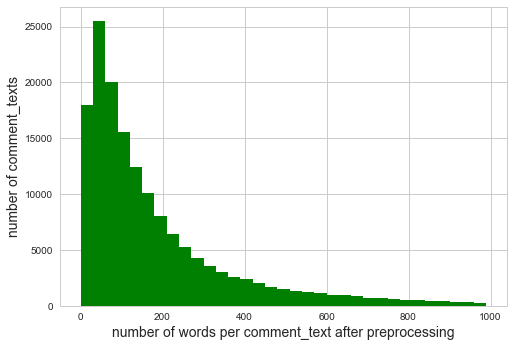

In [14]:
# comments length distribution after cleaning
# calculate the number of words per comment after preprocessing
n_words_clean = [len(comment) for comment in train_text_clean]

# histogram plot of the number of words each comment contains
fig_n_words_clean = plt.figure()
plt.hist(n_words_clean,bins = np.arange(0,1000,30), color='green')
plt.xlabel('number of words per comment_text after preprocessing',fontsize=14)
plt.ylabel('number of comment_texts',fontsize=14)
plt.show()

# save the figure
fig_n_words.savefig('figure/n_words_clean.eps')

In [190]:
n_words_clean = pd.Series(n_words_clean)
n_words_clean.describe()

count    159571.000000
mean        236.922373
std         369.762643
min           0.000000
25%          55.000000
50%         121.000000
75%         259.000000
max        5000.000000
dtype: float64

### Word Tokenization

In [7]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_text)
train_encoded = tokenizer.texts_to_sequences(train_text)
test_encoded = tokenizer.texts_to_sequences(test_text)
# vocabulary size
print('The vocabulary size is {}.'.format(len(tokenizer.word_index)))
# examples
print(train_encoded[0])

The vocabulary size is 210337.
[688, 75, 1, 126, 130, 177, 29, 672, 4530, 12115, 1118, 86, 331, 51, 2282, 11478, 50, 6869, 15, 60, 2761, 148, 7, 2948, 34, 117, 1221, 15232, 2831, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3467, 89, 3091, 4584, 2273, 986]


### Word Padding

In [8]:
maxlen = 250
X_train = pad_sequences(train_encoded, maxlen = maxlen, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = maxlen, padding = 'post')

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[class_names].values

In [9]:
print('X_train shape is {}'.format(X_train.shape))
print('y_train shape is {}'.format(y_train.shape))

X_train shape is (159571, 250)
y_train shape is (159571, 6)


---
<a id='step3'></a>
## Step 3: Logistic Regression Model (Benchmark)


In [66]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (1, 6),
    max_features = 20000)
    
word_vectorizer.fit(train_text)
train_features = word_vectorizer.transform(train_text)
test_features = word_vectorizer.transform(test_text)

In [69]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
scores = []

for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C = 0.2, solver = 'sag')
    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv = 3, scoring = 'roc_auc'))
    scores.append(cv_score)
    print('CV score for class "{}"" is {}'.format(class_name, cv_score))
    classifier.fit(train_features, train_target)
    # [:,1] for those = 1, which is toxic
    submission[class_name] = classifier.predict_proba(test_features)[:,1]
print('Total CV score is {}'.format(np.mean(scores)))
#submission.to_csv('submission.csv', index = False)

CV score for class "toxic"" is 0.9616645047139544
CV score for class "severe_toxic"" is 0.9837446591800686
CV score for class "obscene"" is 0.9817581795211198
CV score for class "threat"" is 0.978320836217707
CV score for class "insult"" is 0.9715901002685747
CV score for class "identity_hate"" is 0.9703486224309047
Total CV score is 0.9745711503887216


---
<a id='step4'></a>
## Step 4: Convolutional Neural Network (CNN) model


In [10]:
# define new callback for ROC AUC score
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):        
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)      
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)      
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [11]:
# function that compile, train and evaluate model
def train_model(model,X_train,y_train,X_val,y_val,batch_size,epochs,filepath):
    # compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # parameters 
    batch_size = batch_size
    epochs = epochs
    # callbacks
    checkpointer =  ModelCheckpoint(filepath=filepath, 
                                    verbose=1, 
                                    save_best_only=True)
    roc = roc_callback(training_data=(X_train,y_train),validation_data=(X_val,y_val)) 
    # fit the model
    history = model.fit(X_train,y_train,
                        validation_data=(X_val,y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc,checkpointer])
    # load the model with the best validation loss
    model.load_weights(filepath)
    return model, history

In [20]:
def history_plot(history,filename):
    fig = plt.figure(figsize=(15, 5))
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()
    
    fig.savefig(filename,bbox_inches = 'tight')
    

### Model Architecture : CNN

In [13]:
max_features = 20000
# build CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(max_features, 100, input_length=maxlen))
model_cnn.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.5))
model_cnn.add(Flatten())
model_cnn.add(Dense(600, activation="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(6, activation="sigmoid"))

#summary
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 16)           4816      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 124, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 32)           1568      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 32)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 32)            0         
__________

### Train Model

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

model_cnn_trained, history_cnn = train_model(model_cnn,
                                             X_train,y_train,
                                             X_val,y_val,
                                             batch_size=512, 
                                             epochs=3,
                                             filepath='saved_models/weights.best.from_scatch_cnn.hdf5')

Train on 129251 samples, validate on 14362 samples
Epoch 1/3
roc-auc: 0.935 - roc-auc_val: 0.9119                                                                                                    

### Evaluation Plot

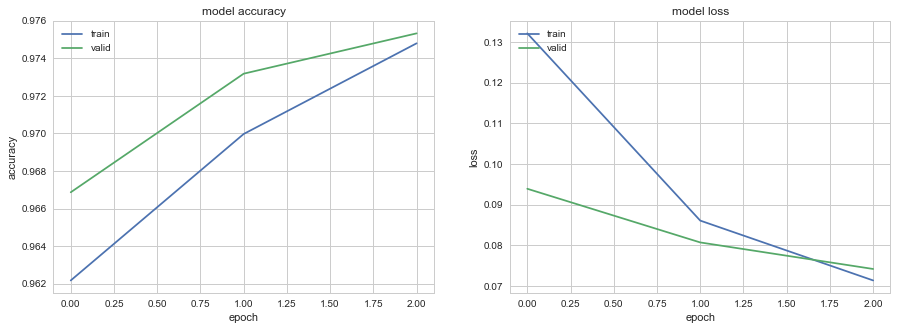

In [21]:
history_plot(history_cnn,'figure/history_cnn.eps')

In [46]:
plot_model(model_cnn, to_file='figure/model_cnn.eps', show_shapes=True, show_layer_names=True)

---
<a id='step5'></a>
## Step 5: Recurrent Neural Network (RNN) model

### Model Architecture : RNN

In [18]:
# build model
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 100, input_length=maxlen))
model_rnn.add(Bidirectional(LSTM(128, return_sequences=True)))
model_rnn.add(GlobalMaxPool1D())
model_rnn.add(Dropout(0.25))
model_rnn.add(Dense(60, activation="relu"))
model_rnn.add(Dropout(0.25))
model_rnn.add(Dense(6, activation="sigmoid"))

# summary
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 256)          234496    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 60)                15420     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 366       
Total para

### Train Model

In [19]:
model_rnn_trained, history_rnn = train_model(model_rnn,
                                X_train,y_train,
                                X_val,y_val,
                                batch_size=512, 
                                epochs=5,
                                filepath='saved_models/weights.best.from_scratch_rnn.hdf5')

Train on 129251 samples, validate on 14362 samples
Epoch 1/5
roc-auc: 0.9394 - roc-auc_val: 0.937                                                                                                    

### Evaluation Plot

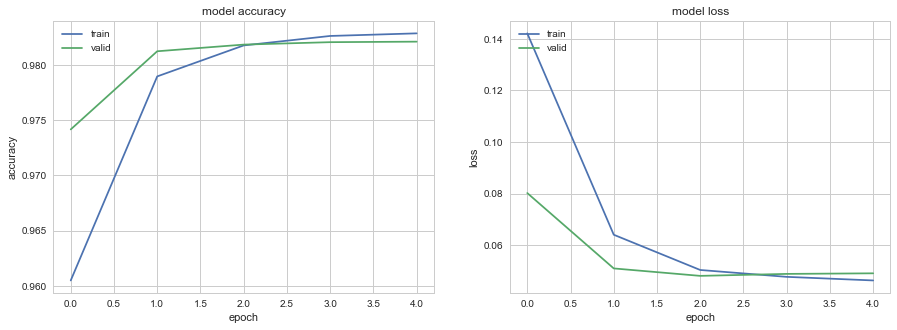

In [22]:
history_plot(history_rnn,'figure/history_rnn.eps')

In [50]:
plot_model(model_rnn, to_file='figure/model_rnn.eps', show_shapes=True, show_layer_names=True)

---
<a id='step6'></a>
## Step 6: Transfer Learning (GloVe) model

In [24]:
# load the whole embedding into memory
def create_embeddings_index(filename):
    embeddings_index = dict()
    f = open(filename, encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index.keys()))
    return embeddings_index

In [25]:
# create a weight matrix for words in training docs (look up word vectors in embeddings_index)
def create_embeddings_matrix(tokenizer, embeddings_index):
    vocab_size = len(tokenizer.word_index) + 1
    embeddings_matrix = np.zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embeddings_vector = embeddings_index.get(word)
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
    return embeddings_matrix

### Create Embedding Matrix

In [26]:
# GloVe model
# load the whole embedding into memory
embeddings_index_glove = create_embeddings_index('pre_trained/glove.6B.100d.txt')
# create a weight matrix for the embedding layer from a loaded embedding
embeddings_matrix_glove = create_embeddings_matrix(tokenizer, embeddings_index_glove)

Loaded 400000 word vectors.


### Model Architecture : GloVe + RNN

In [29]:
# define the model
vocab_size = len(tokenizer.word_index) + 1

model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights = [embeddings_matrix_glove], input_length = maxlen, trainable = False))
model_glove.add(Bidirectional(LSTM(128, return_sequences=True)))
model_glove.add(GlobalMaxPool1D())
model_glove.add(Dropout(0.25))
model_glove.add(Dense(60, activation="relu"))
model_glove.add(Dropout(0.25))
model_glove.add(Dense(6, activation="sigmoid"))

# summary
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 100)          21033800  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 250, 256)          234496    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 60)                15420     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 366       
Total para

### Train Model

In [30]:
model_glove_trained, history_glove = train_model(model_glove,
                                     X_train,y_train,
                                     X_val,y_val,
                                     batch_size=512, 
                                     epochs=5,
                                     filepath='saved_models/weights.best.glove.hdf5')

Train on 129251 samples, validate on 14362 samples
Epoch 1/5
roc-auc: 0.9632 - roc-auc_val: 0.9663                                                                                                    

In [51]:
# more training based on the previous model training
model_glove_trained_2, history_glove_2 = train_model(model_glove_trained,
                                                     X_train,y_train,
                                                     X_val,y_val,
                                                     batch_size=512, 
                                                     epochs=5,
                                                     filepath='saved_models/weights.best.glove_2.hdf5')

Train on 129251 samples, validate on 14362 samples
Epoch 1/5
roc-auc: 0.9841 - roc-auc_val: 0.9826                                                                                                    

### Evaluation Plot

In [65]:
plot_model(model_glove, to_file='figure/model_glove.eps', show_shapes=True, show_layer_names=True)

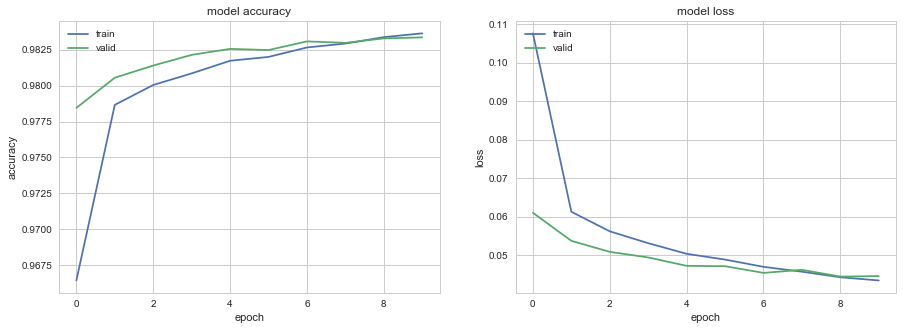

In [64]:
fig = plt.figure(figsize=(15, 5))
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_glove.history['acc']+history_glove_2.history['acc']); 
plt.plot(history_glove.history['val_acc']+history_glove_2.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history_glove.history['loss']+history_glove_2.history['loss']); 
plt.plot(history_glove.history['val_loss']+history_glove_2.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()
    
fig.savefig('figure/history_glove.eps',bbox_inches = 'tight')